# Project

## Build Model to Predict Whether Loans Will Be Charged Off

### Import Libraries

In [1]:
#import libraries

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from sklearn.utils import resample

import time
import random

Using TensorFlow backend.


In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000
random_seed=42

In [3]:
%%time
filename = "loan.csv"
df_full = pd.read_csv(filename)
df_full.shape

CPU times: user 47.6 s, sys: 18.7 s, total: 1min 6s
Wall time: 1min 12s


(2260668, 145)

In [4]:
%%time
#load sample of csv
#data set is very large (> 2 million), so load 100,000 rows to build model to save computational power
#load sample of csv
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 100000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
df = pd.read_csv(filename, skiprows=skip)



CPU times: user 13.5 s, sys: 1.16 s, total: 14.7 s
Wall time: 15.6 s


In [5]:
#reorder columns alphabetically 
df = df.reindex(sorted(df.columns), axis=1)

#display 10 random rows from dataframe
df.sample(10, random_state=random_seed)

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,debt_settlement_flag_date,deferral_term,delinq_2yrs,delinq_amnt,desc,disbursement_method,dti,dti_joint,earliest_cr_line,emp_length,emp_title,funded_amnt,funded_amnt_inv,grade,hardship_amount,hardship_dpd,hardship_end_date,hardship_flag,hardship_last_payment_amount,hardship_length,hardship_loan_status,hardship_payoff_balance_amount,hardship_reason,hardship_start_date,hardship_status,hardship_type,home_ownership,id,il_util,initial_list_status,inq_fi,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,max_bal_bc,member_id,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,next_pymnt_d,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,open_acc_6m,open_act_il,open_il_12m,open_il_24m,open_rv_12m,open_rv_24m,orig_projected_additional_accrued_interest,out_prncp,out_prncp_inv,payment_plan_start_date,pct_tl_nvr_dlq,percent_bc_gt_75,policy_code,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_bal_joint,revol_util,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_mths_since_last_major_derog,sec_app_num_rev_accts,sec_app_open_acc,sec_app_open_act_il,sec_app_revol_util,settlement_amount,settlement_date,settlement_percentage,settlement_status,settlement_term,sub_grade,tax_liens,term,title,tot_coll_amt,tot_cur_bal,tot_hi_cred_lim,total_acc,total_bal_ex_mort,total_bal_il,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
75721,0,0.0,NY,NaN,130000.0,NaN,Individual,44254.0,3966.0,92.7,0.0,35.7493,0.0,N,NaN,NaN,1,0,NaN,Cash,21.00,NaN,Jan-1996,< 1 year,DIrector Finance,28000,28000.0,D,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MORTGAGE,NaN,NaN,f,NaN,NaN,0,707.37,17.76,Oct-2013,Oct-2016,707.37,Aug-2014,28000,Charged Off,NaN,NaN,191.0,216.0,66.0,27.0,4.0,7.0,NaN,NaN,NaN,77.0,NaN,17.0,NaN,NaN,0.0,4.0,5.0,5.0,8.0,12.0,6.0,12.0,5.0,10.0,0.0,0.0,0.0,0.0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,96.0,60.0,1,0,0.0,credit_card,n,3575.25,50792,NaN,89.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D1,0.0,60 months,Debt Consolidation,795.0,442542.0,492772.0,30,113757.0,NaN,54500.0,NaN,95145.0,10648.630000,10648.63,3940.79,0.0,3132.59,56500.0,NaN,Source Verified,NaN,105xx
80184,0,1.0,CA,NaN,65000.0,NaN,Individual,2087.0,588.0,88.0,0.0,0.0000,0.0,N,NaN,NaN,1,0,Borrower added on 12/26/12 > Pay off three (...,Cash,11.48,NaN,Nov-1998,10+ years,NaN,17700,17700.0,C,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RENT,NaN,NaN,f,NaN,NaN,0,633.44,17.27,Jan-2013,Mar-2017,1259.43,Dec-2015,17700,Fully Paid,NaN,NaN,132.0,168.0,2.0,2.0,1.0,20.0,NaN,NaN,NaN,109.0,20.0,NaN,20.0,NaN,0.0,2.0,3.0,3.0,6.0,3.0,4.0,8.0,3.0,5.0,0.0,0.0,0.0,1.0,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,78.0,33.3,1,0,0.0,debt_consolidation,n,0.00,4446,NaN,85.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,C5,0.0,36 months,Loan 2012,0.0,10437.0,33030.0,14,10437.0,NaN,4900.0,NaN,27830.0,22796.390007,22796.39,5096.39,0.0,17700.00,5200.0,NaN,Source Verified,NaN,919xx
19864,0,4.0,VA,37.0,58000.0,NaN,Individual,15585.0,49277.0,2.8,0.0,0.0000,0.0,N,NaN,NaN,0,0,NaN,Cash,21.31,NaN,Oct-1991,7 years,Multimedia web desi

In [6]:
df.shape

(100000, 145)

## Data Preparation

In [7]:
#many columns have multiple null values
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 145 columns):
acc_now_delinq                                100000 non-null int64
acc_open_past_24mths                          97862 non-null float64
addr_state                                    100000 non-null object
all_util                                      61902 non-null float64
annual_inc                                    100000 non-null float64
annual_inc_joint                              5280 non-null float64
application_type                              100000 non-null object
avg_cur_bal                                   96948 non-null float64
bc_open_to_buy                                96766 non-null float64
bc_util                                       96716 non-null float64
chargeoff_within_12_mths                      99994 non-null float64
collection_recovery_fee                       100000 non-null float64
collections_12_mths_ex_med                    99994 non-null 

In [8]:
#3 columns are 100% null, these should be dropped
df.isnull().all().value_counts()

False    142
True       3
dtype: int64

In [9]:
#drop 100% null columns
null_columns=df.columns[df.isnull().all()]
df[null_columns].isnull().sum()
empty_cols = null_columns.tolist()
for col in empty_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
print("The following empty columns have been dropped: " + "\n \n" + str(empty_cols))

The following empty columns have been dropped: 
 
['id', 'member_id', 'url']


In [10]:
#drop text columns
#is it possible that some useful data could be scraped from these text columns, but that is out of the scope of a short project
text_cols = ['desc','emp_title','title']
for col in text_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
print("The following columns have been dropped: " + "\n \n" + str(text_cols))



The following columns have been dropped: 
 
['desc', 'emp_title', 'title']


In [11]:
#percentage of null columns in remaining columns
df.isnull().sum() / df.shape[0] * 100.00

acc_now_delinq                                 0.000
acc_open_past_24mths                           2.138
addr_state                                     0.000
all_util                                      38.098
annual_inc                                     0.000
annual_inc_joint                              94.720
application_type                               0.000
avg_cur_bal                                    3.052
bc_open_to_buy                                 3.234
bc_util                                        3.284
chargeoff_within_12_mths                       0.006
collection_recovery_fee                        0.000
collections_12_mths_ex_med                     0.006
debt_settlement_flag                           0.000
debt_settlement_flag_date                     98.552
deferral_term                                 99.545
delinq_2yrs                                    0.000
delinq_amnt                                    0.000
disbursement_method                           

In [12]:
#replace multiple hardship columns with a single hardship flag

hardship_cols = [
'hardship_amount',                             
'hardship_dpd',                                 
'hardship_end_date',                           
'hardship_last_payment_amount',
'hardship_length',
'hardship_loan_status',
'hardship_payoff_balance_amount',
'hardship_reason',
'hardship_start_date',
'hardship_status',
'hardship_type']

for col in hardship_cols:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
print("The following columns have been dropped: " + "\n \n" + str(hardship_cols))


#replace hardship flag Y/N with 1/0
df.hardship_flag.value_counts()
df.loc[df['hardship_flag'] == 'N', 'hardship_flag'] = 0
df.loc[df['hardship_flag'] == 'Y', 'hardship_flag'] = 1


The following columns have been dropped: 
 
['hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type']


 Annual Income can probably be merged with annual income joint, but first need to check that annual income joint is always greater than or equal to annual income

In [13]:
#can annual_inc and annual_inc_joint be merged?

df_inc = df.loc[df['annual_inc_joint'].notnull(), ['annual_inc','annual_inc_joint']]
df_inc['joint_greater_than'] = df_inc.annual_inc_joint > df_inc.annual_inc
df_inc['joint_greater_than_or_equal'] = df_inc.annual_inc_joint >= df_inc.annual_inc
print(df_inc.joint_greater_than.value_counts())
print(df_inc.joint_greater_than_or_equal.value_counts())

True     5212
False      68
Name: joint_greater_than, dtype: int64
True    5280
Name: joint_greater_than_or_equal, dtype: int64


In [14]:
#merge annual_inc and annual_inc_joint

df['annual_inc'] = df.apply(lambda row: row['annual_inc_joint'] if pd.notnull(row['annual_inc_joint']) else row['annual_inc'],axis=1)

In [15]:
#drop all other columns relating to 2nd application, just keep joint application 1 or 0
%time
sec_list = []
for col in df.columns:
    if 'sec_app' in col:
        sec_list.append(col)
    if 'joint' in col:
        sec_list.append(col)
for col in sec_list:
    if col in df.columns:
        df.drop(col, axis=1, inplace=True)
print("The following columns have been dropped: " + "\n \n" + str(sec_list))

df.application_type.value_counts()


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
The following columns have been dropped: 
 
['annual_inc_joint', 'dti_joint', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_major_derog', 'sec_app_num_rev_accts', 'sec_app_open_acc', 'sec_app_open_act_il', 'sec_app_revol_util', 'verification_status_joint']


Individual    94720
Joint App      5280
Name: application_type, dtype: int64

In [16]:
df.loc[df['application_type'] == 'Individual','application_type'] = 0
df.loc[df['application_type'] == 'Joint App','application_type'] = 1
df.rename(columns={'application_type': 'joint_app'}, inplace=True)
df.joint_app.value_counts()

0    94720
1     5280
Name: joint_app, dtype: int64

In [17]:
#fill null income values with zipcode average
df = df.dropna(axis=0, subset=['zip_code'])


df['annual_inc'] = df.groupby("zip_code")['annual_inc'].transform(lambda x: x.fillna(x.mean()))

In [18]:
#drop columns with more than 2% null values
df = df.loc[:, df.isnull().mean() < .02]

In [19]:
df = df.dropna(how='any',axis=0) 

In [20]:
df.shape

(99693, 50)

In [21]:
#policy code does not add anything and addr_state info should be better provided by zip_code
df.drop(['addr_state','policy_code'], axis=1, inplace=True)

In [22]:
#some columns that should be numeric or datetimes are strings
%time
df['earliest_cr_line_date'] = pd.to_datetime(df['earliest_cr_line'])
df['issue_d'] = pd.to_datetime(df['issue_d'])
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'])
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'])
df['term'] = pd.to_numeric(df['term'].str.replace(' months', ''))



CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


In [23]:
#convert datetime to ordinal so they can be processed by classifiers
date_list = ['last_credit_pull_d','issue_d','last_pymnt_d','earliest_cr_line_date']

for col in date_list:
    df[col] = df[col].apply(lambda x: x.toordinal())

#### Create target variable

target variable (loan_status) changed to 1 (charged off) or 0 (not charged off)

In [24]:

df.loan_status.value_counts()

Fully Paid                                             45905
Current                                                40687
Charged Off                                            11454
Late (31-120 days)                                       974
In Grace Period                                          414
Late (16-30 days)                                        188
Does not meet the credit policy. Status:Fully Paid        43
Does not meet the credit policy. Status:Charged Off       28
Name: loan_status, dtype: int64

In [25]:
#drop all that are not fully paid or charged off as those accounts are still active and may become fully paid or charged off in time. Including them would lead to data leakage

df.loc[(df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off'),'loan_status'] = 'Charged Off'
df.loc[(df['loan_status'] == 'Does not meet the credit policy. Status:Fully Paid'),'loan_status'] = 'Fully Paid'
df = df[(df['loan_status'] == "Fully Paid") | (df['loan_status'] == "Charged Off")]
df.loc[df['loan_status'] != 'Charged Off','loan_status'] = 0
df.loc[df['loan_status'] == 'Charged Off','loan_status'] = 1

In [26]:
df.loan_status.value_counts(normalize=True)

0    0.80007
1    0.19993
Name: loan_status, dtype: float64

In [27]:
#reset index after removing rows
df = df.reset_index(drop=True)
df.head()

,acc_now_delinq,annual_inc,joint_app,chargeoff_within_12_mths,collection_recovery_fee,collections_12_mths_ex_med,debt_settlement_flag,delinq_2yrs,delinq_amnt,disbursement_method,dti,earliest_cr_line,funded_amnt,funded_amnt_inv,grade,hardship_flag,home_ownership,initial_list_status,inq_last_6mths,installment,int_rate,issue_d,last_credit_pull_d,last_pymnt_amnt,last_pymnt_d,loan_amnt,loan_status,open_acc,out_prncp,out_prncp_inv,pub_rec,pub_rec_bankruptcies,purpose,pymnt_plan,recoveries,revol_bal,revol_util,sub_grade,tax_liens,term,total_acc,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,verification_status,zip_code,earliest_cr_line_date
0,0,42000.0,0,0.0,0.0,0.0,N,0,0,Cash,15.09,Mar-2004,2500,2475.0,C,0,RENT,f,0,84.92,13.56,737029,737060,2504.11,737060,2500,0,3,0.0,0.0,0,0.0,other,n,0.0,3319,31.6,C1,0.0,36,6,2501.285667,2476.27,1.29,0.0,2500.0,Not Verified,194xx,731641
1,0,19764.0,0,0.0,0.0,0.0,N,0,0,Cash,30.72,Oct-1992,6000,6000.0,B,0,MORTGAGE,w,1,195.64,10.72,737029,737060,6065.81,737060,6000,0,7,0.0,0.0,1,1.0,credit_card,n,0.0,6896,65.7,B2,0.0,36,21,6056.880592,6056.88,56.88,0.0,6000.0,Not Verified,347xx,727472
2,0,88000.0,0,0.0,0.0,0.0,N,1,0,Cash,19.43,Jan-2008,20000,19975.0,C,0,MORTGAGE,f,1,712.16,16.91,737029,737060,20059.18,737060,20000,0,7,0.0,0.0,1,1.0,house,n,0.0,2819,31.0,C5,0.0,36,19,20012.215000,19987.20,12.21,0.0,20000.0,Source Verified,945xx,733042
3,0,42000.0,0,0.0,0.0,0.0,N,0,0,Cash,1.00,Jun-2003,35000,35000.0,A,0,OWN,w,0,1099.85,8.19,737029,737060,35047.78,737060,35000,0,6,0.0,0.0,0,0.0,debt_consolidation,n,0.0,40,0.2,A4,0.0,36,27,35007.965000,35007.96,7.96,0.0,35000.0,Source Verified,553xx,731367
4,0,176000.0,1,0.0,0.0,0.0,N,0,0,Cash,0.00,Sep-2000,10000,10000.0,B,0,MORTGAGE,w,1,216.04,10.72,737029,737091,10089.38,737060,10000,0,11,0.0,0.0,1,1.0,home_improvement,n,0.0,0,0.0,B2,0.0,60,23,10074.487653,10074.49,74.49,0.0,10000.0,Not Verified,806xx,730364


In [28]:
df['loan_status'] = df['loan_status'].astype(str).astype(int)

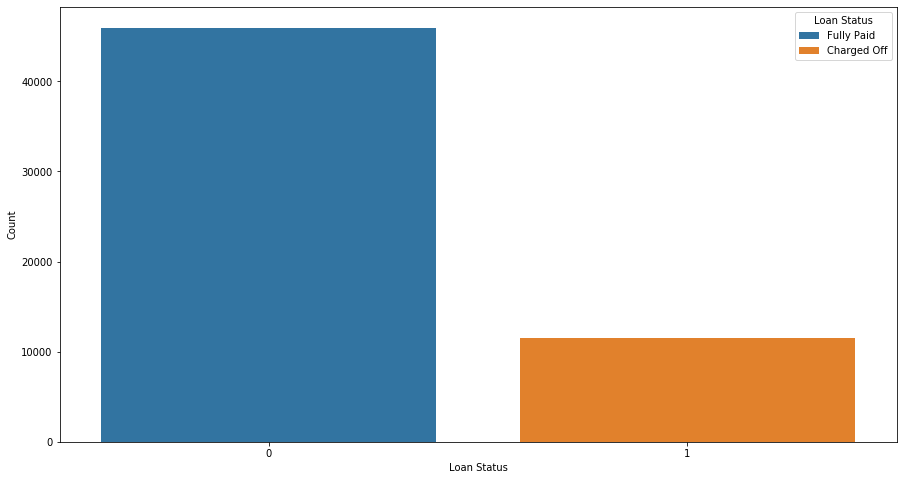

In [29]:
plt.figure(figsize=(15,8))
ax = sns.countplot(x='loan_status',data=df,hue='loan_status',dodge=False)
ax.set_xlabel('Loan Status')
ax.set_ylabel('Count')
h,l = ax.get_legend_handles_labels()
labels=["Fully Paid", "Charged Off"]
ax.legend(h,labels,title="Loan Status", loc="upper right") 
plt.savefig('class_imbalance.png')
plt.show;


In [30]:
#encode categorical variables

dummies_list = list(df.select_dtypes(include=['object']).columns)


In [31]:
df_dummies = pd.get_dummies(df, prefix=dummies_list, columns=dummies_list)

In [32]:
#define X and y variables
y = df_dummies['loan_status']
X = df_dummies.drop('loan_status', axis=1)

In [33]:
#split into train, test and validation datasets (60/20/20)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [34]:
#scale numeric data to normalise. scaler is trained on test data and then fit to test/val 
#minmaxscaler normalises all numeric data to between 0 & 1

scaler = MinMaxScaler()
numeric_list = list(X_train.select_dtypes(include=['float','int']).columns)

X_train[numeric_list] = scaler.fit_transform(X_train[numeric_list])



In [35]:
#transform val and test data sets
X_val[numeric_list] = scaler.transform(X_val[numeric_list])
X_test[numeric_list] = scaler.transform(X_test[numeric_list])

There is a class imbalance in the target variable. This means classifiers will be much better at identifying th majority class than the minority, which is a problem as normally it is classifying the minority class that is driving the business case.

Can deal with this by undersampling majority, oversampling minority, or by ignoring it and trying a classifier anyway (this obviously doesn't get rid of the problem but is a good place to start with a base model). I will try all 3 and compare

#### Undersampling

In [36]:
df_train = pd.concat([X_train, y_train], axis=1)
df_majority = df_train[df_train['loan_status']==0]
df_minority = df_train[df_train['loan_status']==1]

df_majority_undersampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),  # to match minority class
                                 random_state=random_seed)

df_us = pd.concat([df_majority_undersampled, df_minority])

In [37]:
df_train.loan_status.value_counts()

0    27604
1     6854
Name: loan_status, dtype: int64

In [38]:
df_us.loan_status.value_counts()

1    6854
0    6854
Name: loan_status, dtype: int64

In [39]:
y_train_us = df_us['loan_status']
X_train_us = df_us.drop('loan_status', axis=1)

#### Oversampling

In [40]:
df_minority_oversampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=random_seed)
df_os = pd.concat([df_minority_oversampled, df_majority])

In [41]:
df_train.loan_status.value_counts()

0    27604
1     6854
Name: loan_status, dtype: int64

In [42]:
df_os.loan_status.value_counts()

1    27604
0    27604
Name: loan_status, dtype: int64

In [43]:
y_train_os = df_os['loan_status']
X_train_os = df_os.drop('loan_status', axis=1)

#### Use SMOTE (Synthetic Minority Over-sampling TEchnique) to oversample minority class
SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

In [44]:

# Previous original class distribution
print(y_train.value_counts()) 
# Fit SMOTE to training data

smote = SMOTE()

X_train_sm, y_train_sm = smote.fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(y_train_sm.value_counts()) 

0    27604
1     6854
Name: loan_status, dtype: int64


1    27604
0    27604
Name: loan_status, dtype: int64


#### Use ADASYN (Adaptive Synthetic) sampling to oversample minority class

ADASYN is similar to SMOTE, but uses a weighted distribution to generate new samples, generating more synthetic data for examples that are harder to learn

In [45]:
# Previous original class distribution
print(y_train.value_counts()) 
# Fit SMOTE to training data

ada = ADASYN()

X_train_ada, y_train_ada = smote.fit_sample(X_train, y_train) 

# Preview synthetic sample class distribution
print('\n')
print(y_train_ada.value_counts()) 

0    27604
1     6854
Name: loan_status, dtype: int64


1    27604
0    27604
Name: loan_status, dtype: int64


### Modelling 

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, precision_score, accuracy_score,f1_score, recall_score,roc_auc_score

from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import SGDClassifier
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.model_selection import cross_val_predict, cross_val_score

### Base Model
Base model logistic regression, without fixing class imblanace or tuning hyperparameters

In [47]:
logreg = LogisticRegression()
base_model = logreg.fit(X_train,y_train)

train_prob = base_model.predict_proba(X_train)[:,1]
val_prob = base_model.predict_proba(X_val)[:,1]

print ('train accuracy:', base_model.score(X_train, y_train),'//','val accuracy:', base_model.score(X_val, y_val))

train accuracy: 0.9877241859655232 // val accuracy: 0.9855476231934529


Accuracy is not a good metric for imabalanced classification, so I will use recall

In [48]:
pred_base = logreg.predict(X_train)

In [49]:
metric_dict = {'accuracy': accuracy_score(y_train,pred_base),
              'precision': precision_score(y_train,pred_base),
              'recall': recall_score(y_train,pred_base),
              'f1': f1_score(y_train,pred_base),
               'roc_auc': roc_auc_score(y_train,pred_base)
              }
    
keys = list(metric_dict. keys())
values = list(metric_dict. values())

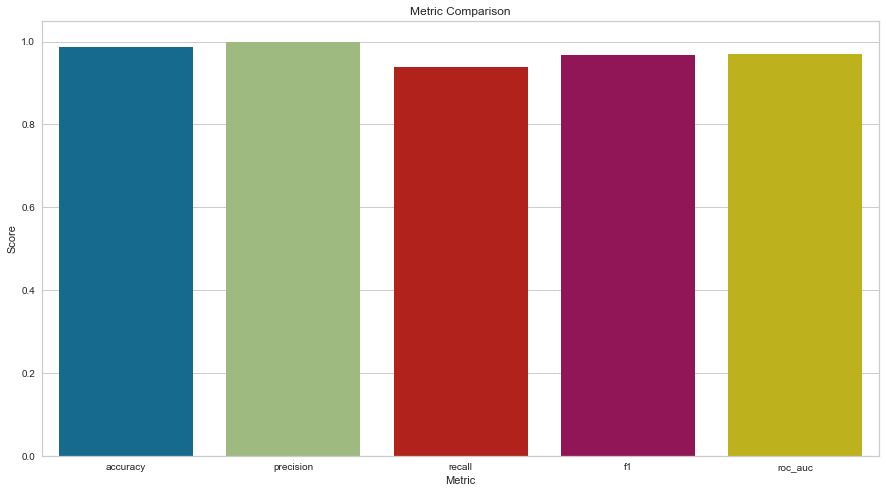

In [50]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=keys,y=values)
ax.set(xlabel='Metric', ylabel='Score', title='Metric Comparison')
plt.savefig('metric_comparison.png');


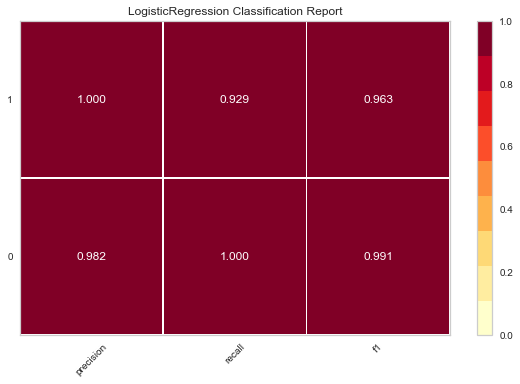

In [51]:
visualizer = ClassificationReport(logreg)
visualizer.fit(X_train, y_train)
visualizer.score(X_val, y_val)
visualizer.show();

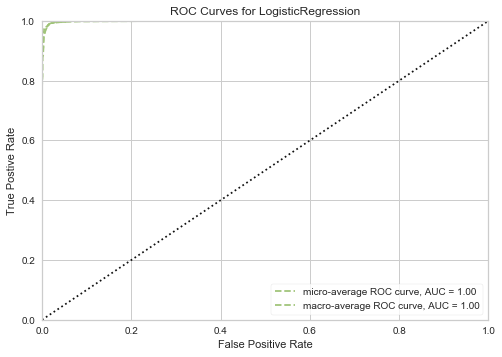

In [52]:
roc = ROCAUC(logreg,per_class=False)
roc.fit(X_train, y_train)
roc.score(X_val, y_val)
plt.savefig('base_auc.png')
roc.show();

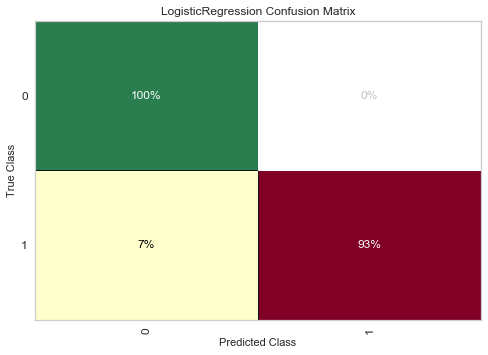

In [53]:
cm = ConfusionMatrix(logreg, percent=True)
cm.fit(X_train, y_train)
cm.score(X_val, y_val)
plt.savefig('base_cm.png')
cm.show();

## Tuning hyperparameters & Comparison with Over/Undersampling/SMOTE techniques

#### Base model

In [54]:
#pipeline for logistic regression

pipe_logreg = Pipeline([
    ('clf', LogisticRegression())
])

parameters_logreg = {
    "clf__C": [0.1,1,10],
    "clf__class_weight": ['balanced'],
#     "clf__solver": ['newton-cg','lbfgs','sag','saga'],
    "clf__max_iter":[10,50,100]
#     "clf__penalty": ['l1','l2'],
#     'clf__tol':[0.00005,0.0001, 0.0005]
}

gs_logreg = GridSearchCV(estimator=pipe_logreg,
            param_grid=parameters_logreg,
            scoring='recall',
            cv=KFold(5,shuffle=True,random_state=42), 
            return_train_score = True, verbose=1,n_jobs=-1)

# Fit using grid search
best_model_base = gs_logreg.fit(X_train, y_train)

# Best accuracy
print('Best recall score: %.3f' % gs_logreg.best_score_)

# Best params
print('\nBest params:\n', gs_logreg.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.0min finished


Best recall score: 0.968

Best params:
 {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__max_iter': 100}


#### Undersampling

In [55]:
pipe_logreg_us = Pipeline([
    ('clf', LogisticRegression())
])

parameters_logreg_us = {
  "clf__C": [0.1,1,10],
    "clf__class_weight": ['balanced'],
#     "clf__solver": ['newton-cg','lbfgs','sag','saga'],
    "clf__max_iter":[10,50,100]
#     "clf__penalty": ['l1','l2'],
#     'clf__tol':[0.00005,0.0001, 0.0005]
}

gs_logreg_us = GridSearchCV(estimator=pipe_logreg_us,
            param_grid=parameters_logreg_us,
            scoring='recall',
            cv=KFold(5,shuffle=True,random_state=42), 
            return_train_score = True, verbose=1,n_jobs=-1)

# Fit using grid search
best_model_us = gs_logreg_us.fit(X_train_us, y_train_us)

# Best accuracy
print('Best recall score: %.3f' % gs_logreg_us.best_score_)

# Best params
print('\nBest params:\n', gs_logreg_us.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  1.1min finished


Best recall score: 0.964

Best params:
 {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__max_iter': 100}


#### Oversampling

In [56]:
pipe_logreg_os = Pipeline([
    ('clf', LogisticRegression())
])

parameters_logreg_os = {
  "clf__C": [0.1,1,10],
    "clf__class_weight": ['balanced'],
#     "clf__solver": ['newton-cg','lbfgs','sag','saga'],
    "clf__max_iter":[10,50,100]
#     "clf__penalty": ['l1','l2'],
#     'clf__tol':[0.00005,0.0001, 0.0005]
}

gs_logreg_os = GridSearchCV(estimator=pipe_logreg_os,
            param_grid=parameters_logreg_os,
            scoring='recall',
            cv=KFold(5,shuffle=True,random_state=42), 
            return_train_score = True, verbose=1,n_jobs=-1)

# Fit using grid search
best_model_os = gs_logreg_os.fit(X_train_os, y_train_os)

# Best accuracy
print('Best recall score: %.3f' % gs_logreg_os.best_score_)

# Best params
print('\nBest params:\n', gs_logreg_os.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.7min finished


Best recall score: 0.995

Best params:
 {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__max_iter': 100}


#### SMOTE

In [57]:
pipe_logreg_sm = Pipeline([
    ('clf', LogisticRegression())
])

parameters_logreg_sm = {
  "clf__C": [0.1,1,10],
    "clf__class_weight": ['balanced'],
#     "clf__solver": ['newton-cg','lbfgs','sag','saga'],
    "clf__max_iter":[10,50,100]
#     "clf__penalty": ['l1','l2'],
#     'clf__tol':[0.00005,0.0001, 0.0005]
}

gs_logreg_sm = GridSearchCV(estimator=pipe_logreg_sm,
            param_grid=parameters_logreg_sm,
            scoring='recall',
            cv=KFold(5,shuffle=True,random_state=42), 
            return_train_score = True, verbose=1,n_jobs=-1)

# Fit using grid search
best_model_sm = gs_logreg_sm.fit(X_train_sm, y_train_sm)

# Best accuracy
print('Best recall score: %.3f' % gs_logreg_sm.best_score_)

# Best params
print('\nBest params:\n', gs_logreg_sm.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.5min finished


Best recall score: 0.989

Best params:
 {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__max_iter': 100}


#### ADASYN

In [58]:
pipe_logreg_ada = Pipeline([
    ('clf', LogisticRegression())
])

parameters_logreg_ada = {
  "clf__C": [0.1,1,10],
    "clf__class_weight": ['balanced'],
#     "clf__solver": ['newton-cg','lbfgs','sag','saga'],
    "clf__max_iter":[10,50,100]
#     "clf__penalty": ['l1','l2'],
#     'clf__tol':[0.00005,0.0001, 0.0005]
}

gs_logreg_ada = GridSearchCV(estimator=pipe_logreg_ada,
            param_grid=parameters_logreg_ada,
            scoring='recall',
            cv=KFold(5,shuffle=True,random_state=42), 
            return_train_score = True, verbose=1,n_jobs=-1)

# Fit using grid search
best_model_ada = gs_logreg_ada.fit(X_train_ada, y_train_ada)

# Best accuracy
print('Best recall score: %.3f' % gs_logreg_ada.best_score_)

# Best params
print('\nBest params:\n', gs_logreg_ada.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.5min finished


Best recall score: 0.989

Best params:
 {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__max_iter': 50}


In [59]:
score_dict = {'base_model':best_model_base.best_score_,
            'undersampling_model': best_model_us.best_score_,
              'oversampling_model': best_model_os.best_score_,
            'SMOTE_model': best_model_sm.best_score_,
             'ADASYN_model':best_model_ada.best_score_}
    
keys = list(score_dict. keys())
values = list(score_dict. values())

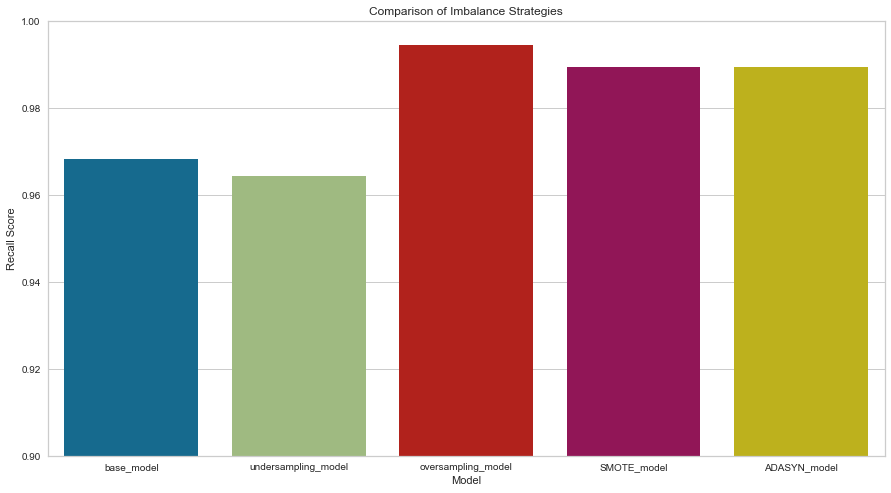

In [60]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=keys,y=values);
ax.set(xlabel='Model', ylabel='Recall Score', title='Comparison of Imbalance Strategies')
plt.savefig('imb_comparison.png')
plt.ylim(0.9, 1);

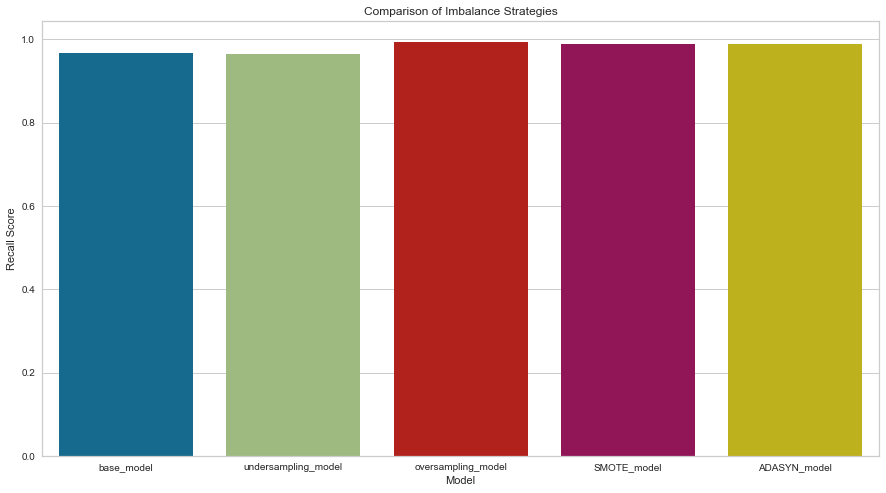

In [61]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=keys,y=values);
ax.set(xlabel='Model', ylabel='Recall Score', title='Comparison of Imbalance Strategies')
plt.savefig('imb_comparison_full.png');
